我们分析了每个lambda下预测成功的embedding的分布情况，显示不同lambda下embedding的分布几乎一样

📂 正在加载数据集: cache/lambda_icl_qwen_0.6b/train_oracle_5120_1.pt ...
   样本总数: 5120
   Embedding 维度: 384
   可解样本数: 3583
⚡ 为了可视化清晰，随机采样 3000 个样本...
🚀 正在运行 t-SNE (将 384维 降至 2维)...
   t-SNE 完成。
🎨 正在绘图...


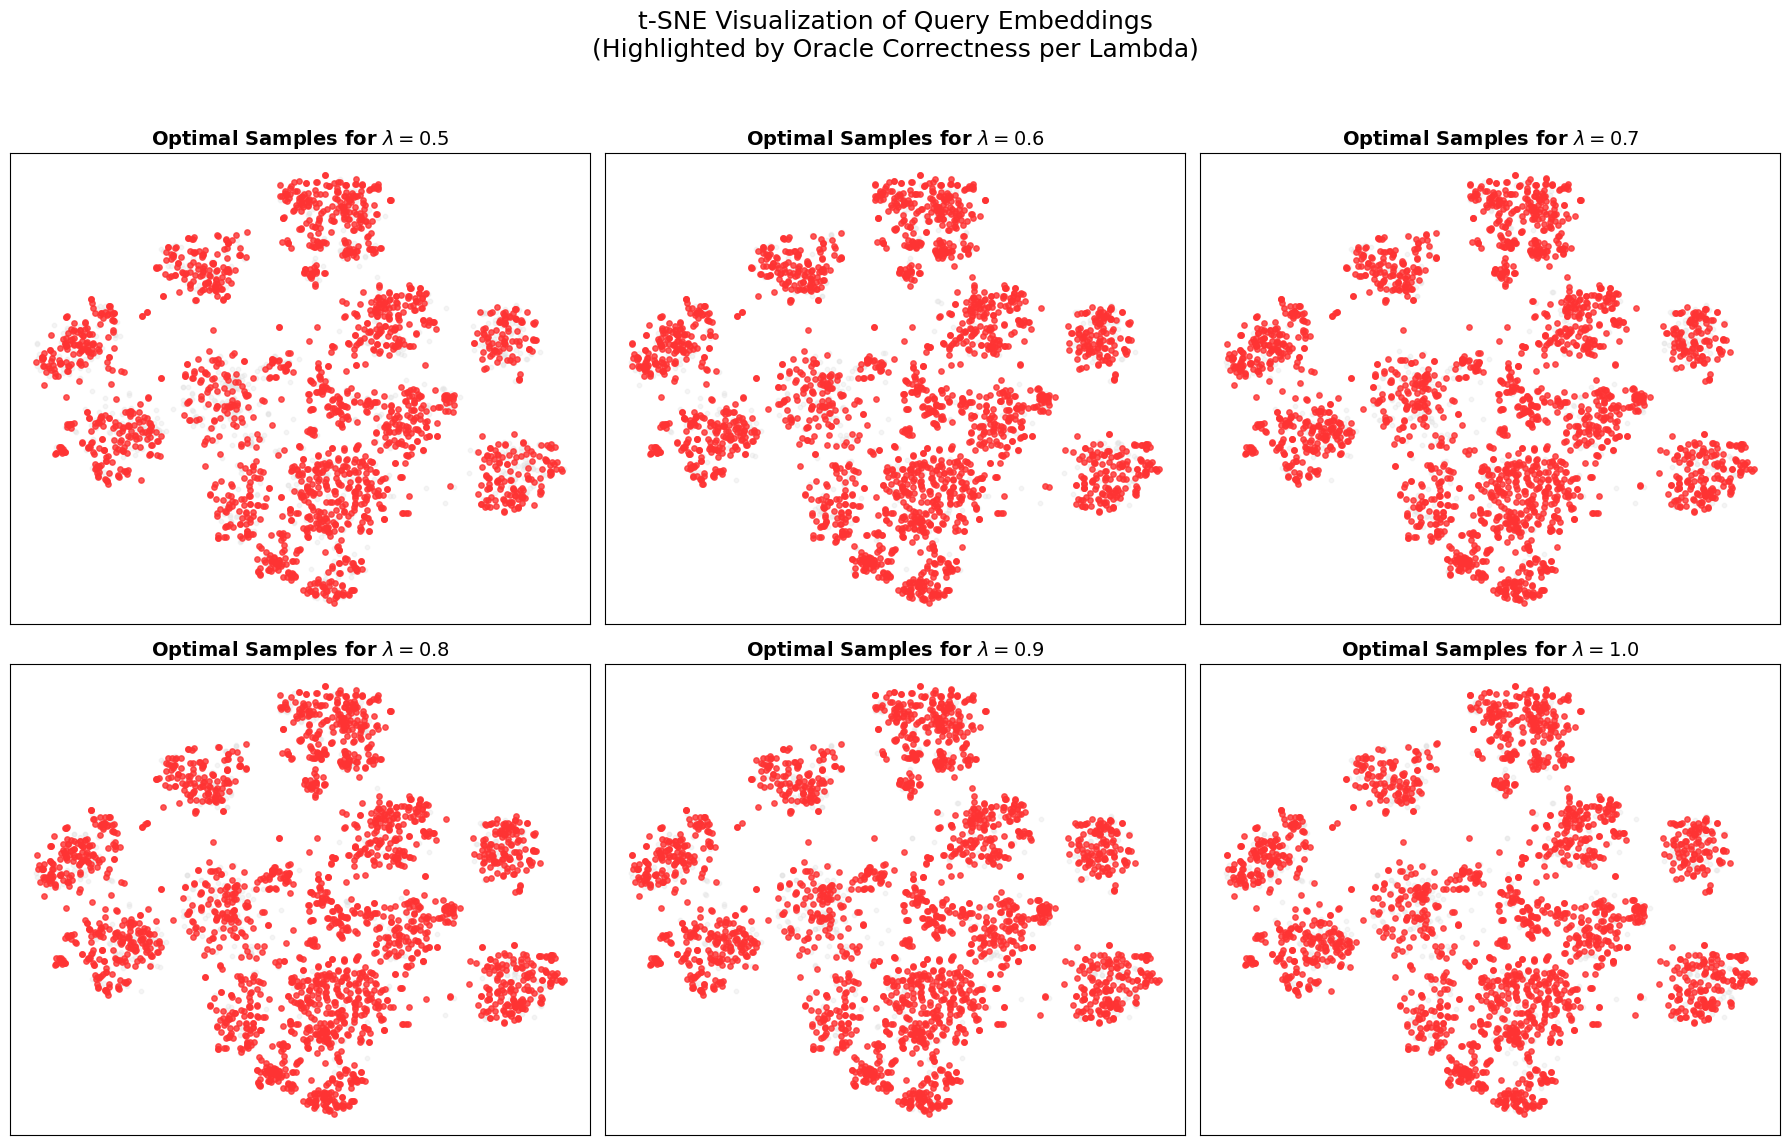


📊 简单统计分析:
   适合 Lambda=0.5 的样本数: 1958
   适合 Lambda=1.0 的样本数: 2192
   两者都适合(重叠)的样本数: 1551
   重叠率 (Overlap / Union): 59.68%


In [2]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

CACHE_FILE = "cache/lambda_icl_qwen_0.6b/train_oracle_5120_1.pt" 

TARGET_LAMBDAS = {
    "0.5": 10,
    "0.6": 12,
    "0.7": 14,
    "0.8": 16,
    "0.9": 18,
    "1.0": 20
}


print(f"📂 正在加载数据集: {CACHE_FILE} ...")
# 加载数据集
dataset = torch.load(CACHE_FILE, weights_only=False)

query_embs = dataset.tensors[0].numpy()
target_dists = dataset.tensors[1].numpy()

total_samples = len(query_embs)
print(f"   样本总数: {total_samples}")
print(f"   Embedding 维度: {query_embs.shape[1]}")

has_solution = (target_dists.sum(axis=1) > 0)
valid_indices = np.where(has_solution)[0]

print(f"   可解样本数: {len(valid_indices)}")

if len(valid_indices) > 3000:
    print("⚡ 为了可视化清晰，随机采样 3000 个样本...")
    sampled_indices = np.random.choice(valid_indices, 3000, replace=False)
else:
    sampled_indices = valid_indices

# 取出采样的数据
X = query_embs[sampled_indices]
Y = target_dists[sampled_indices]

print("🚀 正在运行 t-SNE (将 384维 降至 2维)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_2d = tsne.fit_transform(X)
print("   t-SNE 完成。")

print("🎨 正在绘图...")

# 设置画布：2行3列
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 定义颜色：背景点颜色和高亮颜色
color_bg = '#E0E0E0' # 浅灰色
color_hl = '#FF3333' # 亮红色

keys = sorted(TARGET_LAMBDAS.keys())

for i, lam_key in enumerate(keys):
    idx = TARGET_LAMBDAS[lam_key]
    ax = axes[i]
    is_optimal = Y[:, idx] > 0.5
    
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=color_bg, s=10, alpha=0.3, label='Other Samples')

    ax.scatter(X_2d[is_optimal, 0], X_2d[is_optimal, 1], c=color_hl, s=15, alpha=0.8, label=f'Works with $\lambda={lam_key}$')
    
    ax.set_title(f"Optimal Samples for $\lambda={lam_key}$", fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(f"t-SNE Visualization of Query Embeddings\n(Highlighted by Oracle Correctness per Lambda)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


idx_05 = TARGET_LAMBDAS["0.5"]
idx_10 = TARGET_LAMBDAS["1.0"]

set_05 = set(np.where(Y[:, idx_05] > 0.5)[0])
set_10 = set(np.where(Y[:, idx_10] > 0.5)[0])

overlap = set_05.intersection(set_10)
print("\n📊 简单统计分析:")
print(f"   适合 Lambda=0.5 的样本数: {len(set_05)}")
print(f"   适合 Lambda=1.0 的样本数: {len(set_10)}")
print(f"   两者都适合(重叠)的样本数: {len(overlap)}")
print(f"   重叠率 (Overlap / Union): {len(overlap) / len(set_05.union(set_10)):.2%}")


我们继续分析成功预测和失败预测 embedding的分布情况

📂 Loading Dataset: cache/lambda_icl_qwen_0.6b/train_oracle_5120_1.pt ...

📊 样本概览:
   Total: 5120
   Solvable (可解): 3583 (69.98%)
   Unsolvable (不可解): 1537 (30.02%)

📚 Loading Corpus to compute Density Stats...


Batches: 100%|██████████| 980/980 [00:03<00:00, 276.90it/s]


   Computing Max Similarity (Density)...


100%|██████████| 6/6 [00:00<00:00, 40.02it/s]



📏 密度统计 (Nearest Neighbor Similarity):
   Solvable Mean Sim: 0.7904
   Unsolvable Mean Sim: 0.7512


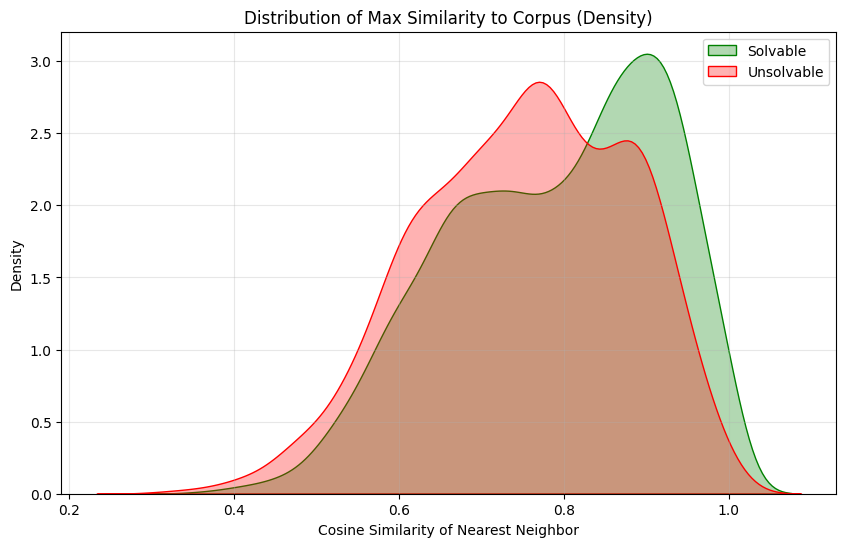

   Running t-SNE...


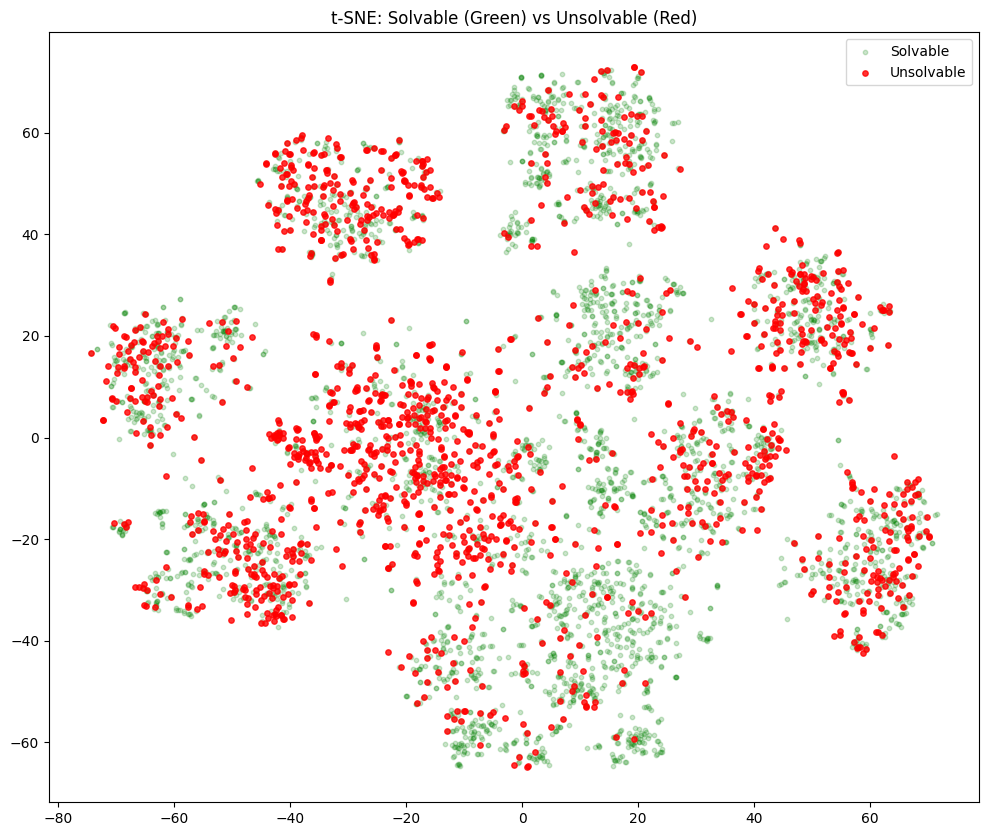


✅ 分析完成。


In [6]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

import data_utils.mtop_loader as dataloader
from config import train_config as config
import utils

CACHE_FILE = "cache/lambda_icl_qwen_0.6b/train_oracle_5120_1.pt" 


print(f"📂 Loading Dataset: {CACHE_FILE} ...")
dataset = torch.load(CACHE_FILE, weights_only=False)
query_embs = dataset.tensors[0] # (N, 384)
target_dists = dataset.tensors[1] # (N, 21)


is_solvable = (target_dists.sum(dim=1) > 0).numpy()

solvable_idxs = np.where(is_solvable)[0]
unsolvable_idxs = np.where(~is_solvable)[0]

print(f"\n📊 样本概览:")
print(f"   Total: {len(is_solvable)}")
print(f"   Solvable (可解): {len(solvable_idxs)} ({len(solvable_idxs)/len(is_solvable):.2%})")
print(f"   Unsolvable (不可解): {len(unsolvable_idxs)} ({len(unsolvable_idxs)/len(is_solvable):.2%})")

print("\n📚 Loading Corpus to compute Density Stats...")
_, corpus_embs = dataloader.get_corpus()
corpus_embs = corpus_embs.cpu() 

print("   Computing Max Similarity (Density)...")
batch_size = 1000
max_sims = []

for i in tqdm(range(0, len(query_embs), batch_size)):
    batch_q = query_embs[i : i+batch_size]
    sims = torch.matmul(batch_q, corpus_embs.T)
    top2_vals, _ = torch.topk(sims, k=2, dim=1)
    max_sims.append(top2_vals[:, 1].numpy())
    
max_sims = np.concatenate(max_sims)

sim_solvable = max_sims[solvable_idxs]
sim_unsolvable = max_sims[unsolvable_idxs]

print(f"\n📏 密度统计 (Nearest Neighbor Similarity):")
print(f"   Solvable Mean Sim: {sim_solvable.mean():.4f}")
print(f"   Unsolvable Mean Sim: {sim_unsolvable.mean():.4f}")

plt.figure(figsize=(10, 6))
sns.kdeplot(sim_solvable, fill=True, label='Solvable', color='green', alpha=0.3)
sns.kdeplot(sim_unsolvable, fill=True, label='Unsolvable', color='red', alpha=0.3)
plt.title("Distribution of Max Similarity to Corpus (Density)")
plt.xlabel("Cosine Similarity of Nearest Neighbor")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

tsne_embs = query_embs.numpy()
tsne_labels = is_solvable

print("   Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_2d = tsne.fit_transform(tsne_embs)

plt.figure(figsize=(12, 10))
# 先画 Solvable (Green) 做背景
plt.scatter(X_2d[tsne_labels, 0], X_2d[tsne_labels, 1], c='green', s=10, alpha=0.2, label='Solvable')

plt.scatter(X_2d[~tsne_labels, 0], X_2d[~tsne_labels, 1], c='red', s=15, alpha=0.8, label='Unsolvable')

plt.title("t-SNE: Solvable (Green) vs Unsolvable (Red)")
plt.legend()
plt.show()

print("\n✅ 分析完成。")


In [14]:
import torch
import numpy as np
import os
from tqdm import tqdm
import re
import pandas as pd

from config import train_config as config
import utils
import data_utils.mtop_loader as dataloader
from models.embedding_model import EmbeddingModel
from models.llm_wrapper import LLMWrapper
from utils import device

NUM_SAMPLES_TO_INSPECT =128
OUTPUT_DIR = "results/analysis"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "inspection_report.csv")

LAMBDA_CANDIDATES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

utils.setup_logging(log_level="INFO")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Starting CSV Inspection. Output: {OUTPUT_FILE}")

print("Loading Models...")
embedding_model = EmbeddingModel(config.EMBEDDING_MODEL_NAME)
llm_wrapper = LLMWrapper(config.LLM_MODEL_NAME)

corpus_data, corpus_embeddings_cpu = dataloader.get_corpus()
corpus_embeddings = corpus_embeddings_cpu.to(device)

train_raw, _ = dataloader.get_train_val_split_data(
    split='train',
    train_nums=config.PRETRAIN_NUMS,
    val_nums=64,
    seed=config.PRETRAIN_SEED
)

inspect_data = train_raw[:NUM_SAMPLES_TO_INSPECT] if NUM_SAMPLES_TO_INSPECT else train_raw
print(f"Inspecting {len(inspect_data)} samples...")

rows = []

for idx, sample in enumerate(tqdm(inspect_data, desc="Inspecting")):
    query_text = sample['query']
    target_answer = sample['answer']
    
    row_data = {
        "Index": idx,
        "Question": query_text,
        "Answer": target_answer,
    }
    
    query_emb = embedding_model.encode([query_text]) # (1, D)
    query_index = sample.get('corpus_index', -1)
    
    sim_scores_base = torch.matmul(query_emb, corpus_embeddings.T) # (1, Corpus)
    
    correct_lambdas = []

    for lam_val in LAMBDA_CANDIDATES:
        lambda_tensor = torch.tensor(lam_val, device=device)

        selected_indices = []
        selected_embs = torch.zeros((1, 0, embedding_model.dim), device=device)
        
        curr_mask = torch.zeros_like(sim_scores_base, dtype=torch.bool)
        if query_index >= 0:
            curr_mask[0, query_index] = True
        
        for t in range(config.NUM_EXAMPLES):
            if t == 0:
                step_scores = sim_scores_base.clone()
            else:
                sim_to_selected = torch.matmul(selected_embs, corpus_embeddings.T)
                diversity_penalty, _ = torch.max(sim_to_selected, dim=1)
                step_scores = (lambda_tensor * sim_scores_base) - ((1 - lambda_tensor) * diversity_penalty)
            
            step_scores.masked_fill_(curr_mask, -float('inf'))
            best_idx = torch.argmax(step_scores, dim=1).item()
            selected_indices.append(best_idx)
            curr_mask[0, best_idx] = True
            
            new_emb = corpus_embeddings[best_idx].unsqueeze(0).unsqueeze(0)
            selected_embs = torch.cat([selected_embs, new_emb], dim=1)

        examples = [corpus_data[i] for i in selected_indices]

        prompt = llm_wrapper.build_chat_prompt(config.SYSTEM_PROMPT, examples, query_text)
        pred_texts, _ = llm_wrapper.generate_for_evaluation([prompt], max_new_tokens=config.MAX_GEN_TOKENS)
        pred_text = pred_texts[0]

        is_correct = dataloader.check_correct(target_answer, pred_text)
        if is_correct:
            correct_lambdas.append(lam_val)

        mark = "✅" if is_correct else "❌"
        row_data[f"Pred_{lam_val}"] = f"{mark} {pred_text}"
        row_data[f"Retrieved_{lam_val}"] = ' '.join([str(ex) for ex in examples])

    row_data["Is_Solvable"] = len(correct_lambdas) > 0
    row_data["Best_Lambdas"] = str(correct_lambdas)
    
    rows.append(row_data)

df = pd.DataFrame(rows)

base_cols = ["Index", "Is_Solvable", "Best_Lambdas", "Question", "Answer"]

lambda_cols = []
for lam in LAMBDA_CANDIDATES:
    lambda_cols.append(f"Pred_{lam}")
    lambda_cols.append(f"Retrieved_{lam}")

df = df[base_cols + lambda_cols]

df = df.sort_values(by=["Is_Solvable", "Index"], ascending=[False, True])

df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig') # utf-8-sig 兼容 Excel 打开中文
print(f"Successfully saved inspection report to {OUTPUT_FILE}")
print(f"Solvable Samples: {df['Is_Solvable'].sum()}/{len(df)}")


2025-12-06 14:32:21 - root - INFO - Logging setup complete. Outputting to console and file: train.log
Starting CSV Inspection. Output: results/analysis/inspection_report.csv
Loading Models...
2025-12-06 14:32:21 - root - INFO - [EmbeddingModel] Loading embedding model: all-MiniLM-L6-v2...
2025-12-06 14:32:21 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-12-06 14:32:39 - root - INFO - [EmbeddingModel] Model loaded. Embedding dimension: 384
2025-12-06 14:32:39 - models.llm_wrapper - INFO - Loading LLM environment: Qwen/Qwen3-0.6B...
2025-12-06 14:32:55 - models.llm_wrapper - INFO - LLM 'Qwen/Qwen3-0.6B' loaded successfully.
2025-12-06 14:32:55 - data_utils.mtop_loader - INFO - --- Creating Corpus (Action Space) ---
2025-12-06 14:32:55 - data_utils.mtop_loader - INFO - Loading full 'train' split (no global cache used)...
2025-12-06 14:33:15 - data_utils.mtop_loader - INFO - Loading EmbeddingModel (all-MiniLM-L6-v2) for K-Me

Batches: 100%|██████████| 980/980 [00:03<00:00, 280.72it/s]

2025-12-06 14:33:47 - data_utils.mtop_loader - INFO - Full train data and embeddings loaded (15667 samples).
2025-12-06 14:33:47 - data_utils.mtop_loader - INFO - Corpus created. Final size: 15667
2025-12-06 14:33:47 - data_utils.mtop_loader - INFO - Splitting 'train' data: Train=5120, Val=64, Seed=1


2025-12-06 14:33:56 - data_utils.mtop_loader - INFO - Split result -> Train: 5120, Val: 64
Inspecting 128 samples...


Inspecting: 100%|██████████| 128/128 [05:09<00:00,  2.42s/it]

Successfully saved inspection report to results/analysis/inspection_report.csv
Solvable Samples: 93/128


In [44]:
from openai import OpenAI
import os

client = OpenAI(
    api_key="sk-49da8b1a6c6d4f3e8e7a74860f2d11f1", 
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

messages = [
    {"role": "system", "content": "You are an expert assistant for semantic parsing. Given a user utterance, you must convert it into its logical form representation."},
    {"role": "user", "content": "stop and delete the timer"}, {"role": "assistant", "content": "[IN:PAUSE_TIMER [SL:METHOD_TIMER timer ] ]"},
    {"role": "user", "content": "close out of timer"}, {"role": "assistant", "content": "[IN:PAUSE_TIMER  [SL:METHOD_TIMER timer ] ]"},
    {"role": "user", "content": "timer re-start"}, {"role": "assistant", "content": "[IN:RESUME_TIMER [SL:METHOD_TIMER timer ] ]"},
    {"role": "user", "content": "alter timer"}, {"role": "assistant", "content": "[IN:UPDATE_TIMER [SL:METHOD_TIMER  timer ] ]"},
    {"role": "user", "content": "Cancel timer"}, {"role": "assistant", "content": "[IN:DELETE_TIMER [SL:METHOD_TIMER timer ] ]"},
    # {"role": "user", "content": "timer stop"}, {"role": "assistant", "content": "[IN:PAUSE_TIMER [SL:METHOD_TIMER timer ]  ]"},
    # {"role": "user", "content": "stop and remove current timer"}, {"role": "assistant", "content": "[IN:PAUSE_TIMER [SL:METHOD_TIMER timer ] ]"},
    # {"role": "user", "content": "turn off timer"}, {"role": "assistant", "content": "[IN:PAUSE_TIMER  [SL:METHOD_TIMER timer ] ]"},
    {"role": "user", "content": "discontinue timer"}
]

completion = client.chat.completions.create(
    model="qwen3-0.6b",
    messages=messages,
    stream=True,
    temperature=0,     
    top_p=1.0,        
    max_tokens=200,    
    extra_body={
        "enable_thinking": False,
    }
)

reasoning_content = "" 
answer_content = "" 
is_answering = False  
print("=" * 20 + "Thinking Process" + "=" * 20 )

for chunk in completion:
    if not chunk.choices:
        print("Usage:")
        print(chunk.usage)
        continue

    delta = chunk.choices[0].delta

    if hasattr(delta, "reasoning_content") and delta.reasoning_content is not None:
        if not is_answering:
            print(delta.reasoning_content, end="", flush=True)
        reasoning_content += delta.reasoning_content

    # Received content, starting to respond
    if hasattr(delta, "content") and delta.content:
        if not is_answering:
            print("\n" + "=" * 20 + "Complete Response" + "=" * 20)
            is_answering = True
        print(delta.content, end="", flush=True)
        answer_content += delta.content

    if is_answering and hasattr(chunk.choices[0], "finish_reason") and chunk.choices[0].finish_reason is not None:
        print("\n" + "=" * 20 + "Prompt Messages" + "=" * 20)
        # 将历史按 assistant:xxx\n user:xxx\n 格式输出
        for msg in messages:
            if msg["role"] == "assistant":
                print(f"assistant: {msg['content']}")
            elif msg["role"] == "user":
                print(f"user: {msg['content']}")
        print(f"prediction: {answer_content.strip()}")
        print("=" * 55)

2025-12-06 16:16:48 - httpx - INFO - HTTP Request: POST https://dashscope.aliyuncs.com/compatible-mode/v1/chat/completions "HTTP/1.1 200 OK"
====================Thinking Process====================

====================Complete Response====================
[IN:DISCONTINUE_TIMER [SL:METHOD_TIMER timer ] ]
====================Prompt Messages====================
user: stop and delete the timer
assistant: [IN:PAUSE_TIMER [SL:METHOD_TIMER timer ] ]
user: close out of timer
assistant: [IN:PAUSE_TIMER  [SL:METHOD_TIMER timer ] ]
user: timer re-start
assistant: [IN:RESUME_TIMER [SL:METHOD_TIMER timer ] ]
user: alter timer
assistant: [IN:UPDATE_TIMER [SL:METHOD_TIMER  timer ] ]
user: Cancel timer
assistant: [IN:DELETE_TIMER [SL:METHOD_TIMER timer ] ]
user: discontinue timer
prediction: [IN:DISCONTINUE_TIMER [SL:METHOD_TIMER timer ] ]
